In [51]:
# Useful starting lines
from dataloader import *
from finance import *
from section1 import *
from finance import stock, compare
from quotebankexploration import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***
## Quotebank Data Exploration

In [23]:
quotebank_exploration(quotes)

Let's see what the dataset looks like and what is it's shape.


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-11-18-000136,"... let's just take Google, OK, which is the n...",None,[],2018-11-18 19:08:21,1,"[[None, 0.7353], [Warren Buffett, 0.1946], [Ge...",[https://www.insidermonkey.com/blog/stan-druck...,E
1,2018-02-01-005728,All retailers can do more to enforce a policy ...,None,[],2018-02-01 06:07:00,1,"[[None, 0.6646], [Bill Johnson, 0.3354]]",[http://msn.com/en-au/news/australia/west-aust...,E
2,2018-11-19-005699,"And in the past week, Apple told several suppl...",None,[],2018-11-19 13:45:38,1,"[[None, 0.588], [Takashi Mochizuki, 0.412]]",[http://macdailynews.com/2018/11/19/wsj-apple-...,E
3,2018-10-04-008049,appeared to admonish the likes of advertising ...,Tim Cook,"[Q1404825, Q265852, Q7803347, Q7803348]",2018-10-04 12:54:00,1,"[[Tim Cook, 0.9092], [None, 0.0908]]",[http://www.digit.in/general/tim-cook-rebuffs-...,E
4,2018-04-14-008518,benchmarked the data collection practices of o...,None,[],2018-04-14 00:22:22,4,"[[None, 0.941], [Stefano Quintarelli, 0.059]]",[http://www.gulf-times.com/story/588928/Facebo...,E


(26460, 9)

The dataset comprises the following columns : 
 * `quoteID`: Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}").
 * `quotation`: Text of the longest encountered original form of the quotation.
 * `speaker`: Selected most likely speaker. This matches the first speaker entry in `probas`. If none of the speakers is selected, the speaker is defined as "None".
 * `qids`: Wikidata IDs of all aliases that match the selected speaker. If no Wikidata IDs is found, the value is '[]'.
 * `date`: Earliest occurrence date of any version of the quotation.
 * `numOccurrences`: Number of time this quotation occurs in the articles.
 * `probas`: Array representing the probabilities of each speaker having uttered the quotation.
 * `urls`: List of links to the original articles containing the quotation. 
 * `phase`: Corresponding phase of the data in which the quotation first occurred (A-E).

***
## Quotebank Data Pre-processing
We filter and transform the data according to our needs. The first step is to filter out any quotes that are not related to the company, the products or its direction board. To do so, we use a combination of white-listed words (Apple, iPhone, iPad, Macbook etc.), black-listed words that are not related to the Apple company (Big Apple, apple pie, big mac etc.) and relevant speakers (Tim Cook, Steve Jobs etc.). The filtered dataset is then saved as a pickle file.

In [ ]:
keywords_1_word = ["iphone", "ipad", "imac", "ipod", "macbook", "mac", "airpods", \
        "lightening", "magsafe", "aapl", "iwatch", "itunes", "homepod", "macos", "ios", "ipados", \
        "watchos", "tvos", "wwdc", "siri", "facetime", "appstore", "icloud", "iphones"]

keywords_2_words = ["apple watch", "steve jobs", "tim cook", "face id", \
        "pro display xdr", "katherine adams", "eddy cue", "craig federighi"]

keywords_capital = ["Apple"]

black_list = ["Big Apple"]

keywords = {"One word": keywords_1_word, "Two words": keywords_2_words, "Capital words": keywords_capital, "Black list": black_list}

speakers = ["steve jobs", "tim cook", "katherine adams", "eddy cue", "craig federighi", "john giannandrea", "greg joswiak", \
    "sabih khan", "luca maestri", "deirdre o'brien", "johny srouji", "john ternus", "jeff williams", "lisa jakson", \
    "stella low", "isabel ge mahe", "tor myhren", "adrian perica", "phil schiller", "arthur levinson", "james bell", \
    "albert gore", "andrea jung", "monica lozano", "ronald sugar", "susan wagner"]

In [ ]:
for year in range(2008, 2019):
    filter_quotes(f"data/quotes-{str(year)}.json.bz2", speakers = speakers, keywords = keywords, save = f"filtered_quotes_{str(year)}")

In [ ]:
### Baptiste EDA après filtering

This new filtered dataset provides a great preview of Apple mentions in the media.

***
## Yahoo Finance Data Exploration
Eventually, we will use the Yahoo Finance API to recover informations about the stock markets. This API provides quick and easy access to finance metrics for any stock or index. Among the many financial metrics available we have decided to focus on the daily stock price and volume. The former will be an indicator of the long term health of the stock, and the latter of the daily volatility it may experience. In this milestone we will compare the Apple stock ($AAPL) to the S&P500 ($SPY) from 2008 until 2020, which is is a stock market index tracking the performance of 500 large companies listed on stock exchanges in the United States. We have chosen this equity index as it is one of the most tracked indices and generally an indicator of the overall health of the US stock market. We will note that $SPY consists of 6.2% of $AAPL stock.

A stock dataframe consists of the following features: 
 * `Date`: Primary key of the quotation (format: "YYYY-MM-DD").
 * `Open`: Stock price at the daily opening of the market.
 * `High`: Highest stock price reached during the day.
 * `Low`: Lowest stock price reached during the day.
 * `Adj Close`:  Adjusted stock price at the daily close of the market.
 * `Volume`: Amount of stocks that changed hands during the day.

 We will focus our study on the `Open`, `Close` and `Volume`.

## A first preview of the performance of $AAPL
As stated previously we will focus on the Apple stock performance, using the daily opening, daily close and volume metrics from the yfinance API. We load the stock metrics for the year 2019 and perform some first observation on this data.

In [152]:
apple_ticker = "AAPL"
spy_ticker = "SPY"
year = 2019
apple_stock = yf.download(apple_ticker, start=f'{year}-01-01', end=f'{year}-12-31', progress = False)
apple_stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,39.632500,39.840000,39.119999,39.435001,38.282608,140014000
2019-01-02,38.722500,39.712502,38.557499,39.480000,38.326294,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.508709,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.981865,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.901783,219111200


### Price and Volume
As stated previously, we can first look at the performance of the $AAPL stock in term of its stock price and daily volume. Empirically we observe that the days of sharp decreases or increase are often linked to day of high volume volatility. Later on we may look at the QuoteBank dataset if the days of high volatility also see many Apple related quotes.

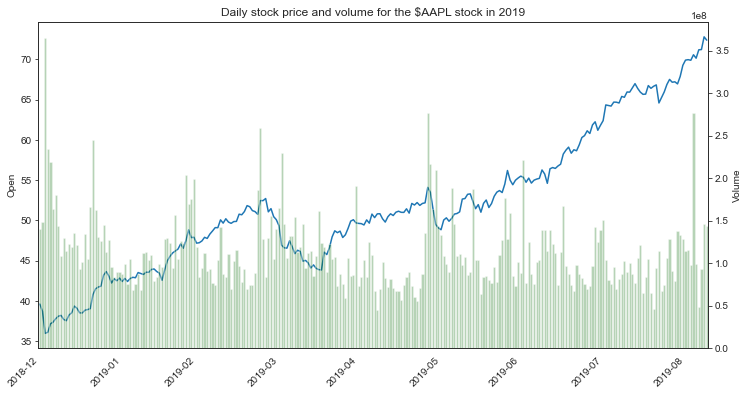

In [153]:
stock(apple_ticker, year = year, fig = "price_volume")

We can also observe with histograms the distribution of the daily volume of exchange of the Apple stock. From our observations it may be fitted appropriately as a left skewed distribution, and the average daily volume sits around 112 millions stocks trade daily. Later on we will focus on the days of high volatility, i.e with higher volume than usual.

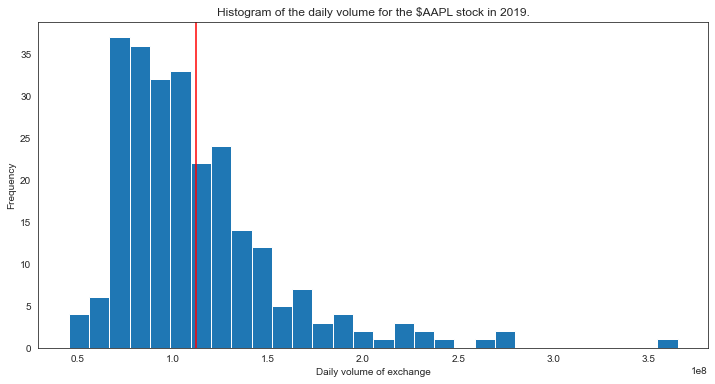

In [164]:
stock(apple_ticker, year = year, fig = "volume")

### Daily price difference
We pursue this idea of studying the volatility as an indicator of meaningful trading days, by introducing the daily price indicator. By taking the difference between the daily closing and opening price, and dividing by the opening price, we obtain the percentage of increase or decrease of the stock during that day. We observe a gaussian-like distribution of the daily percentage change of the stock price, with a mean slightly above 0 at 0.1799%. We will later on compare this histogram of the daily price change with other major stocks and we will look more closely at the high change days.

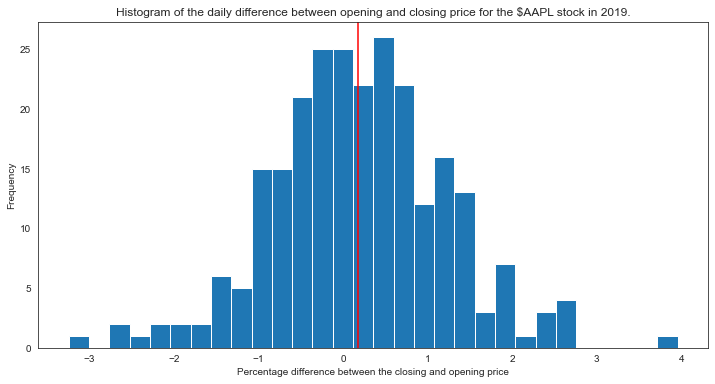

In [163]:
stock(apple_ticker, year = year, fig = "daily_diff")

### Comparison with the overall market
The S&P 500 is regarded as one of the best gauge of large-cap U.S. equities. It is a weighted average of some of the 500 best and largest american companies, 6.2% of which is the Apple stock. It is often taken as a general indicator of the overall health of the US stock market, and individual stock may be compared to the S&P. In the following figure, we observe than during the 2019 trading period, the Apple stock generally underperformed the S&P but still ended up relatively with the same performance. Both are highly correlated.

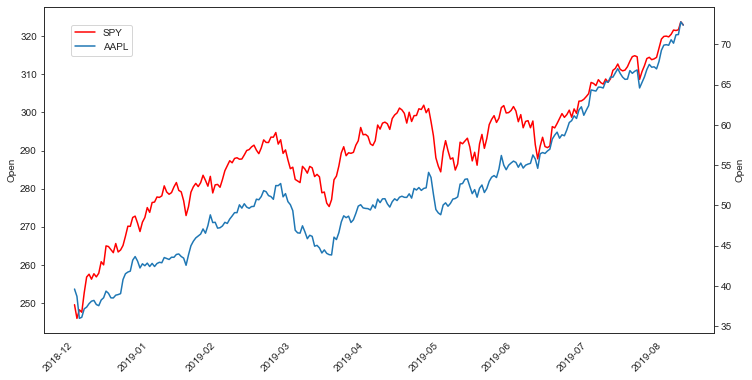

In [144]:
compare(spy_ticker, apple_ticker, year = year, fig = "price")

Looking at the volume of exchange of both SPY and AAPL, we observe again a strong correlation between the two. One of the reasons is that the day of high volume exchange are often close or during the week of the quarterly results. Most companies in the S&P 500 provide their quarterly results in the same time-frame.

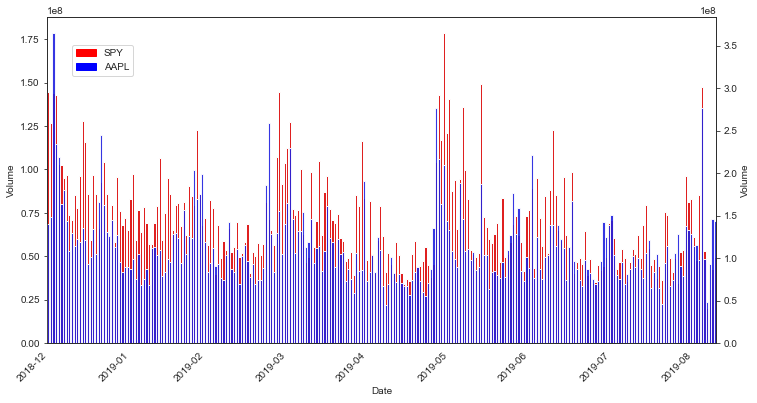

In [145]:
compare(spy_ticker, apple_ticker, year = year, fig = "volume")

Finally we can again take a closer look at the distribution of the daily price difference. Interestingly enough we observe that both stocks performs *in average* with a mean daily difference close to 0 with an normal distribution. However the Apple stock has a greater variance than the S&P, in other words the Apple stock is more suggest to volatility than the S&P. In a financial context, this is seen as being a riskier security with the same yielding. 

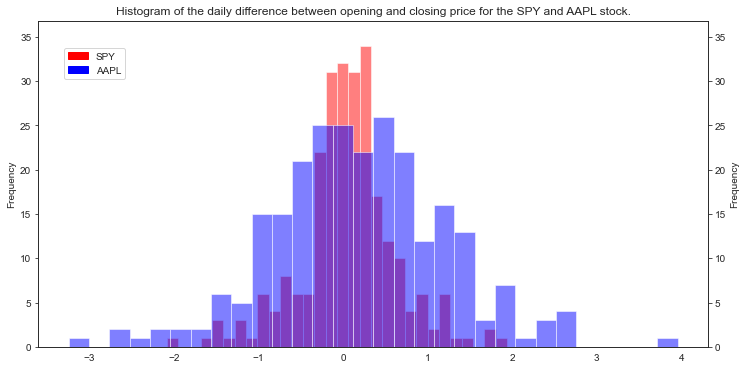

In [172]:
compare(spy_ticker, apple_ticker, year = year, fig = "daily_diff")

In [ ]:
keywords_1_word = ["iphone", "ipad", "imac", "ipod", "macbook", "mac", "airpods", \
        "lightening", "magsafe", "aapl", "iwatch", "itunes", "homepod", "macos", "ios", "ipados", \
        "watchos", "tvos", "wwdc", "siri", "facetime", "appstore", "icloud", "iphones"]

keywords_2_words = ["apple watch", "steve jobs", "tim cook", "face id", \
        "pro display xdr", "katherine adams", "eddy cue", "craig federighi"]

keywords_capital = ["Apple"]

black_list = ["Big Apple"]

keywords = {"One word": keywords_1_word, "Two words": keywords_2_words, "Capital words": keywords_capital, "Black list": black_list}

speakers = ["steve jobs", "tim cook", "katherine adams", "eddy cue", "craig federighi", "john giannandrea", "greg joswiak", \
    "sabih khan", "luca maestri", "deirdre o'brien", "johny srouji", "john ternus", "jeff williams", "lisa jakson", \
    "stella low", "isabel ge mahe", "tor myhren", "adrian perica", "phil schiller", "arthur levinson", "james bell", \
    "albert gore", "andrea jung", "monica lozano", "ronald sugar", "susan wagner"]

***
### Subtask 1 : 
What is the role of the media coverage in explaining stock market fluctuations ? How does the media coverage of Apple evolve over time ? Are there any specific patterns we can observe across the years, for instance bigger coverage when there is the keynote ? Thousands of events occur around the world every day, and humans notice a small subset of these events. Yet, the media attract attention to specific events. In this regard, a company’s media visibility will definitely affect its stock price. We investigate the reciprocal relationships between the fluctuations of the stock market of Apple and media coverage related to this company for a period of 12 years (2008–2020). 

***
### Subtask 2 
Who are the individuals who have influence over potential customers, and do these influencers have an impact on the Apple company image and eventually, on the stock market ? Personality  plays  a huge  role  in  consumer  buying  behavior. Indeed, the high level of public attention and the positive emotional responses that define celebrity increase the economic opportunities available to a firm. We hypothesize that quotes from celebrities significantly impact the stock market, whereas quotes from ordinary people have no significant predictive power. One defining characteristic of a celebrity is that it is a social actor who attracts large-scale public attention : the greater the number of people who know of and pay attention to the actor, the greater the extent and value of that celebrity. For this subtask - and this subtask only - we won't consider the quotes from undefined speakers (i.e. classified as "none"). 

***

### Subtask 3 :
What is the influence of the public opinions or emotions about Apple expressed in the media on the stock market ? Media influences beliefs by providing compelling information about events. In this regard, the media have been identified to play a significant role in shaping the consensus market opinion. Can a series of news articles make a stock rise? On the other hand, can it send a market into turmoil ? Not only the opinion of the public about the company’s stock but also the opinions about products and services offered by the company would have a significant impact and are worth studying. Understanding the author's opinion from a piece of text is the objective of sentiment analysis. We classify quotes and tweets as positive, negative and neutral based on the sentiment present. To do so, we measure the frequency of positive and negative words in a quote (e.g. negativity frequency = negative words / total words). Words are classified as “negative” or “positive” based on psychosocial dictionaries, for instance negative words include: “fear,” “worry,” “disappoint,” “collapse,” “flaw,” and “ruin”. We want to answer the following questions : are the stock price drops/rises correlated with negative/positive quotes ? Does the market respond appropriately to these words? 